# Test validity step 3 : $P(S_c | ...) \propto s_c^t S_c^{-1} s_c + ln|S_c|$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb

import non_parametric_ML_compsep as katame

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


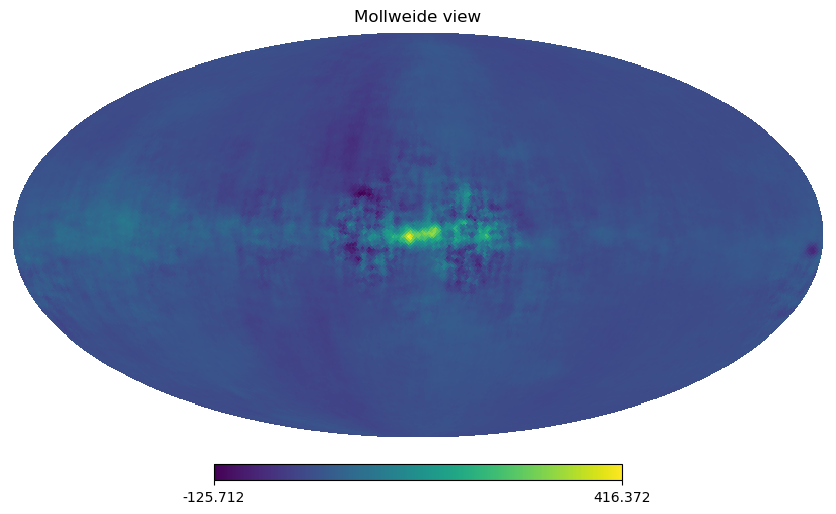

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

In [8]:
red_cov_approx_matrix = katame.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

In [9]:
depth_p = instrument['depth_p']

freq_inverse_noise = katame.get_noise_covar(depth_p, nside)

init_mixing_matrix_obj = katame.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = katame.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [10]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

In [11]:
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = katame.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  254 iterations !!


In [12]:
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = katame.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  286 iterations !!


In [13]:
s_c_map = wiener_filter_term + fluctuation_maps

In [14]:
c_ells_Wishart = katame.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)
# c_ells_Wishart = np.copy(c_ells_input)

# file_ver = 'HistInvWv2c' # 300 samples and no wn, with all 3 options, lmin=2, lmax=2*nside, with cross-correl ; only polarization !
# dir_path = '/Users/mag/Documents/PHD1Y/Space_Work/Inference_Sampling/map_files/'
# path_map_total = dir_path + "Map_invWBR_ver{}_total_CMB_white_noise_{}.fits".format(file_ver, lmax)
# maps_total = hp.read_map(path_map_total, field=None)
# c_ells_Wishart = hp.anafast(maps_total, lmax=lmax, iter=n_iter)[indices_polar]


number_samples = 400
red_c_ells_samples = np.zeros((number_samples, lmax+1, nstokes, nstokes))
c_ells_samples = np.zeros((number_samples, number_correlations, lmax+1))

for i in range(number_samples):
    red_c_ells_samples[i,...] = katame.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
    c_ells_samples[i,...] = katame.get_c_ells_from_red_covariance_matrix(red_c_ells_samples[i,...])


In [15]:
# Get Maximum posterior distribution on those samples

red_param_matrix = np.zeros_like(red_cov_matrix)
cov_maximum_Wishart_posterior = np.zeros((lmax+1,nstokes,nstokes))
c_ell_maximum_posterior_inv_Gamma = np.zeros((nstokes,lmax+1))

red_param_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_Wishart)[lmin:]

for ell in range(lmin,lmax+1):
    param_matrix = (2*ell+1)*red_param_matrix[ell-lmin]
    distribution_inv_Wishart = katame.get_generalized_proba_inverse_wishart_distribution(red_c_ells_samples[:, ell, ...], param_matrix, 2*ell + 1)
    argmax_inv_Wishart = np.argmax(distribution_inv_Wishart)
    cov_maximum_Wishart_posterior[ell] = red_c_ells_samples[argmax_inv_Wishart, ell, ...]

    for nb_stokes in range(nstokes):
        distribution_inv_Gamma = get_log_proba_inverse_gamma_distribution(red_c_ells_samples[:, ell, nb_stokes,nb_stokes], param_matrix[nb_stokes,nb_stokes], 2*ell + 1)
        argmax_inv_Gamma = np.argmax(distribution_inv_Gamma)
        c_ell_maximum_posterior_inv_Gamma[nb_stokes,ell] = red_c_ells_samples[:, ell, nb_stokes,nb_stokes][argmax_inv_Gamma]


c_ell_maximum_posterior_inv_Wishart = katame.get_c_ells_from_red_covariance_matrix(cov_maximum_Wishart_posterior)


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/non_parametric_ML_compsep/proba_functions.py:42: RuntimeWarning: divide by zero encountered in divide
  coefficient = np.linalg.det(param_matrix)**(.5*exposant)/(2**(.5*exposant*dim) * get_multivariate_gamma(.5*exposant, dim) * np.linalg.det(variable)**(.5*ddl))
/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/non_parametric_ML_compsep/proba_functions.py:42: RuntimeWarning: invalid value encountered in divide
  coefficient = np.linalg.det(param_matrix)**(.5*exposant)/(2**(.5*exposant*dim) * get_multivariate_gamma(.5*exposant, dim) * np.linalg.det(variable)**(.5*ddl))
/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/non_parametric_ML_compsep/proba_functions.py:42: RuntimeWarning: overflow encountered in scalar multiply
  coefficient = np.linalg.det(param_matrix)**(.5*exposant)/(2**(.5*exposant*dim) * get_multivariate_gamma(.5*exposant, dim) * np.linalg.det(variable)**(.5

In [16]:
ell_arange = np.arange(c_ells_input.shape[1])

In [19]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

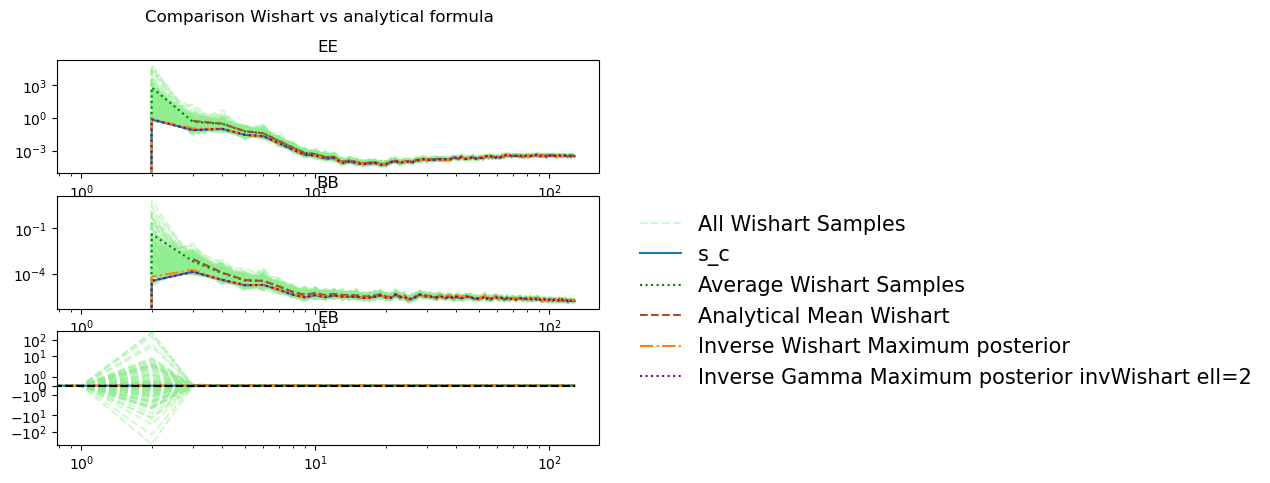

In [23]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison Wishart vs analytical formula")

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange[lmin:], c_ells_samples[0,j,:], '--', color='lightgreen', label='All Wishart Samples', alpha=0.4)
    # for k in range(number_samples):
    #     plt.plot(ell_arange[lmin:], c_ells_samples[k,j,:], '--', color='lightgreen', alpha=0.4)
    plt.plot(ell_arange, c_ells_samples[0,j,:], '--', color='lightgreen', label='All Wishart Samples', alpha=0.4)
    for k in range(number_samples):
        plt.plot(ell_arange, c_ells_samples[k,j,:], '--', color='lightgreen', alpha=0.4)

    plt.plot(ell_arange, c_ells_Wishart.T[:,j], label='s_c')
    # plt.plot(ell_arange[lmin:], noise[j,:], label=r"$\eta$ CG")
    
    

    # plt.plot(ell_arange[lmin:], c_ells_samples[:,j,:].mean(axis=0), ':', color='green', label='Average Wishart Samples')
    plt.plot(ell_arange, c_ells_samples[:,j,:].mean(axis=0), ':', color='green', label='Average Wishart Samples')
    # plt.plot(ell_arange, c_ells_samples_2[:,j,:].mean(axis=0), ':', label='Average Wishart Samples-2')

    min_value_mean = 3
    factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)
    # factor_mean = (2*ell_arange + 1)/(2*ell_arange + 1 - 2 - 2*nstokes)
    plt.plot(ell_arange[min_value_mean:], factor_mean*(c_ells_Wishart.T[:,j][min_value_mean:,...]), '--', color='sienna', label='Analytical Mean Wishart')
    # plt.plot(ell_arange[min_value_mean:], (factor_mean*c_ells_Wishart.T[:,j])[min_value_mean:,...], '--', color='sienna', label='Analytical Mean Wishart')

    plt.plot(ell_arange, c_ell_maximum_posterior_inv_Wishart[j,:], '-.', label='Inverse Wishart Maximum posterior')
    
    if j < nstokes:
        plt.plot(ell_arange, c_ell_maximum_posterior_inv_Gamma[j,:], ':', color='purple', label='Inverse Gamma Maximum posterior invWishart ell=2')

    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
        # plt.ylim(ymax=np.max(100*factor_mean*(c_ells_Wishart.T[:,j][min_value_mean:,...])))
        # plt.ylim(ymax=np.max(100*(factor_mean*c_ells_Wishart.T[:,j])[min_value_mean:,...]))
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()